### IMPORT

In [33]:
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
import plotly.express as px

from imblearn import*
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing, metrics
from sklearn.metrics import accuracy_score, classification_report

from imblearn.under_sampling import InstanceHardnessThreshold


warnings.simplefilter(action='ignore')


### DATA LOADING

In [34]:
url = 'https://drive.google.com/uc?id=1KklvbAJqeG86WZ_K5HjBMYWKYN6yVcV6'
df = pd.read_csv(url)

In [35]:
df = df.drop(columns=['HbA1c_level', 'blood_glucose_level'])

### EDA

In [36]:
print(df['gender'].unique())


['Female' 'Male' 'Other']


In [37]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   gender           100000 non-null  object 
 1   age              100000 non-null  float64
 2   hypertension     100000 non-null  int64  
 3   heart_disease    100000 non-null  int64  
 4   smoking_history  100000 non-null  object 
 5   bmi              100000 non-null  float64
 6   diabetes         100000 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 5.3+ MB


In [39]:
df.describe(include="all")

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,0.000000


In [40]:
# Mengecek duplikasi baris secara keseluruhan
duplicate_rows = df[df.duplicated()]
print("Jumlah baris duplikat:", len(duplicate_rows))

Jumlah baris duplikat: 27328


In [41]:
numerical_features = ['age', 'hypertension', 'heart_disease', 'bmi']
categorical_features = ['gender', 'smoking_history']

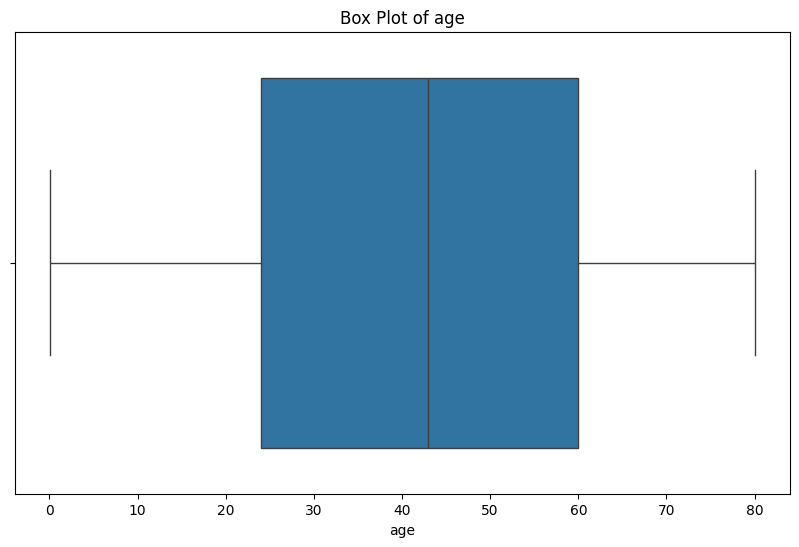

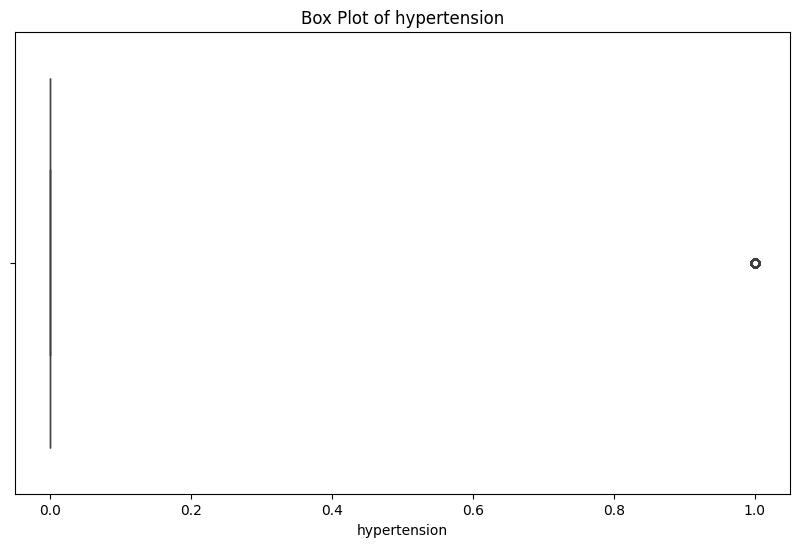

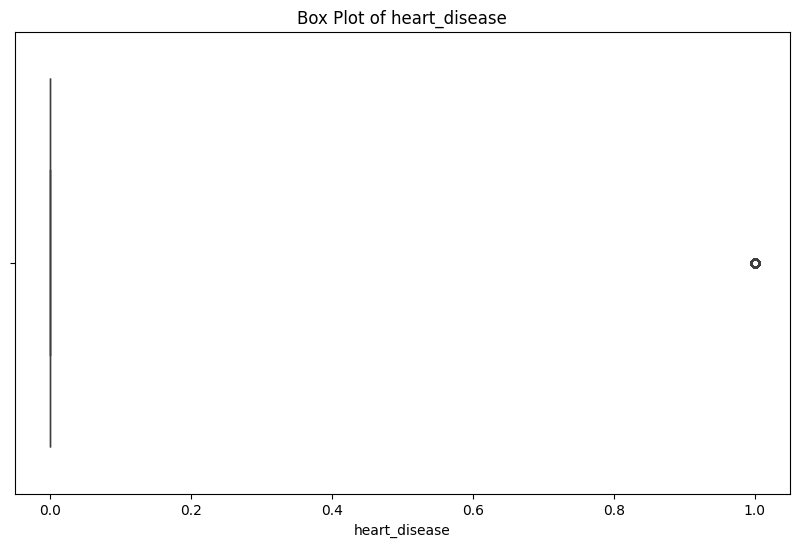

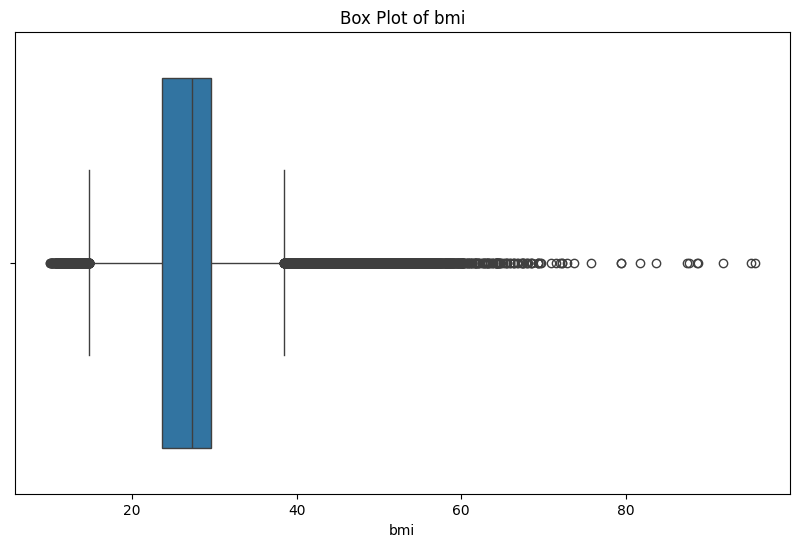

In [42]:
for feature in numerical_features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot of {feature}")
    plt.show()

### DATA CLEANING

In [43]:
df_cleaned = df.drop_duplicates()

print(f"Jumlah baris sebelum dihapus duplikat: {len(df)}")
print(f"Jumlah baris setelah dihapus duplikat: {len(df_cleaned)}")

Jumlah baris sebelum dihapus duplikat: 100000
Jumlah baris setelah dihapus duplikat: 72672


In [44]:
df_cleaned.shape

(72672, 7)

In [45]:
Q1 = df_cleaned[numerical_features].quantile(0.25)
Q3 = df_cleaned[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Buat filter data tanpa outlier
filter = ~((df_cleaned[numerical_features] < (Q1 - 1.5 * IQR)) |
           (df_cleaned[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)

df_ = df_cleaned[filter]

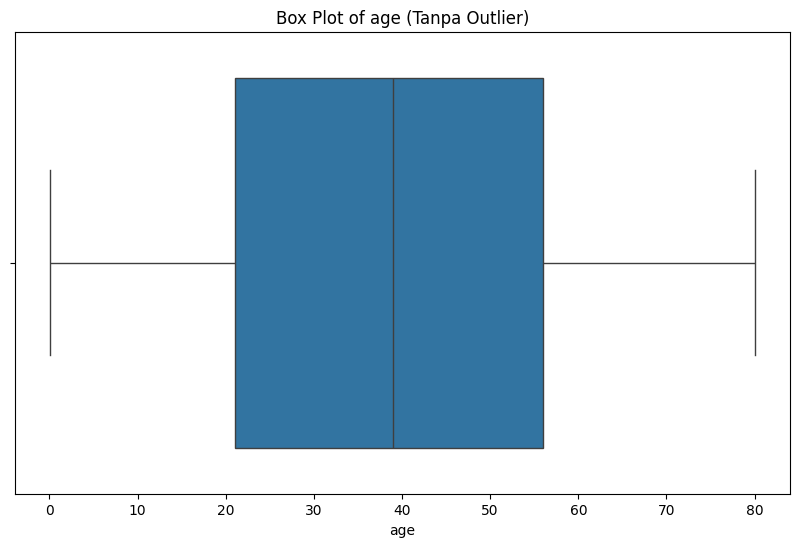

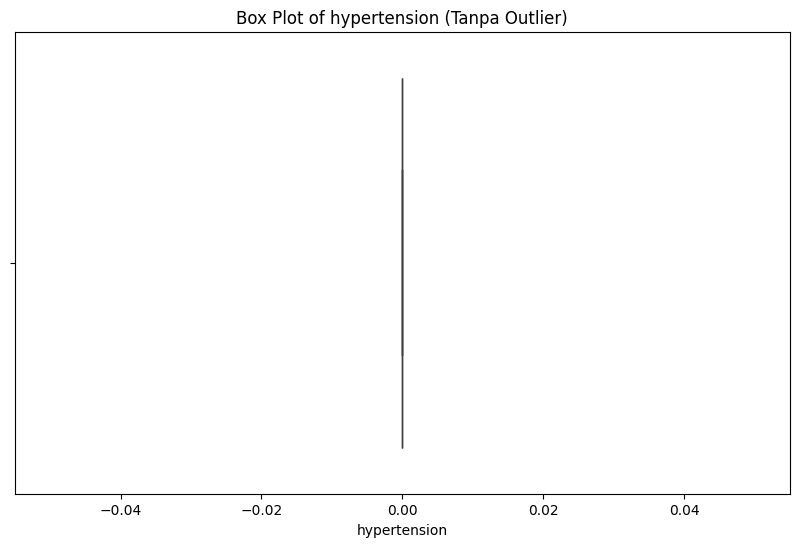

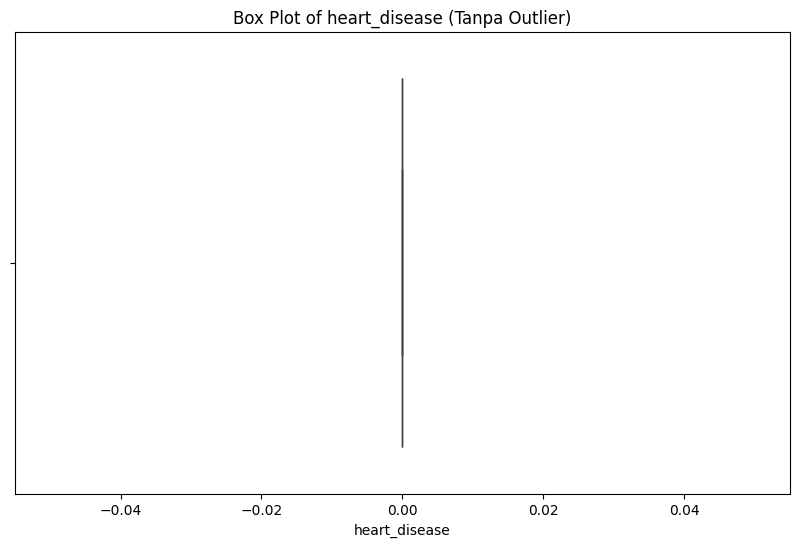

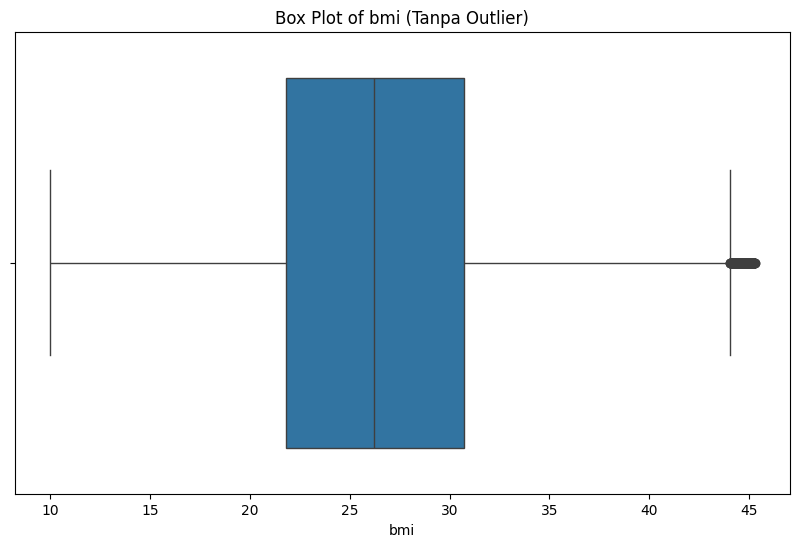

In [46]:
for feature in numerical_features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=df_[feature])
    plt.title(f"Box Plot of {feature} (Tanpa Outlier)")
    plt.show()

In [47]:
print(df_.isnull().sum())

gender             0
age                0
hypertension       0
heart_disease      0
smoking_history    0
bmi                0
diabetes           0
dtype: int64


# ENCODING

In [48]:
df_.drop(df_[df_["gender"]=="Other"].index,inplace=True)
df_.reset_index(drop=True,inplace=True)

In [49]:
one_hot_encoded_data = pd.get_dummies(df_, columns = ["gender", "smoking_history"])
df_ = pd.DataFrame(one_hot_encoded_data)

In [50]:
df_ = df_.rename(columns={
    "gender_Female": "female",
    "gender_Male": "male",

    "smoking_history_never": "never",
    "smoking_history_No Info": "no info",
    "smoking_history_current": "current",
    "smoking_history_former": "former",
    "smoking_history_ever": "ever",
    "smoking_history_not current": "not current"
})

In [51]:
print(df_.columns)


Index(['age', 'hypertension', 'heart_disease', 'bmi', 'diabetes', 'female',
       'male', 'no info', 'current', 'ever', 'former', 'never', 'not current'],
      dtype='object')


In [52]:
df_ = df_.reindex(columns=[
    'age','hypertension','heart_disease','bmi',
    'female','male',
    'never', 'no info', 'current', 'former', 'ever', 'not current',
    'diabetes'
])

In [53]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61797 entries, 0 to 61796
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            61797 non-null  float64
 1   hypertension   61797 non-null  int64  
 2   heart_disease  61797 non-null  int64  
 3   bmi            61797 non-null  float64
 4   female         61797 non-null  bool   
 5   male           61797 non-null  bool   
 6   never          61797 non-null  bool   
 7   no info        61797 non-null  bool   
 8   current        61797 non-null  bool   
 9   former         61797 non-null  bool   
 10  ever           61797 non-null  bool   
 11  not current    61797 non-null  bool   
 12  diabetes       61797 non-null  int64  
dtypes: bool(8), float64(2), int64(3)
memory usage: 2.8 MB


In [54]:
Compare = {"Method":[],"P_Count":[],"N_Count":[],"Score_P":[],"Score_N":[],"Score":[]}

# MODELING

Fungsi berikut akan digunakan untuk memplot ruang sampel setelah pengambilan sampel ulang untuk mengilustrasikan kekhususan suatu algoritma.

In [55]:
def plot_resampling(x_res, y_res, sampler, ax, title=None):
    x_res = pd.DataFrame(x_res)
    ax.scatter(x_res.iloc[:, 0], x_res.iloc[:, 3], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)

Fungsi berikut akan digunakan untuk memplot fungsi keputusan suatu pengklasifikasi yang diberikan beberapa data.

In [56]:
def plot_decision_function(x, y, clf, ax, title=None):
    x = pd.DataFrame(x)
    plot_step = 0.02
    x_min, x_max = x.iloc[:, 0].min() - 1, x.iloc[:, 0].max() + 1
    y_min, y_max = x.iloc[:, 3].min() - 1, x.iloc[:, 3].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    clf.fit(x.iloc[:, [0,3]],y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(x.iloc[:, 0], x.iloc[:, 3], alpha=0.8, c=y, edgecolor="k")
    if title is None:
        title = f"Decision function of {clf.__class__.__name__}"
    ax.set_title(title)

Fungsi berikut akan digunakan untuk memplot distribusi label kelas.

In [57]:
def shareplot(df,target):
    dfi = df.groupby(target).size().reset_index(name="Count")
    fig = px.pie(dfi, values='Count', names=target)
    fig.update_traces(textposition='auto', textinfo='percent+label',sort=False,showlegend=False,rotation=90)
    fig.update_layout(title_text='Class label shares',title_x=0.5)
    fig.show()

Fungsi berikut akan digunakan untuk menampilkan informasi tentang kinerja metode dan skornya.

In [58]:
def info_func(df,target,method,ver=""):
    #Scaling the dataset using standard scaler
    DF = df.copy()
    scal_s = preprocessing.StandardScaler()
    Ns = scal_s.fit_transform(DF.drop(columns=target))
    DFs = pd.DataFrame(Ns,columns = list(DF.drop(columns=target)))
    DFs[target] = DF[target]
    #--------------------------------------------------------------------------------------------------------------------------
    # Defining x_train  x_test  y_train  y_test using train_test_split
    ts = 0.15 #test size
    x = DFs.drop(columns=target).values
    y = DFs[target].values.reshape(-1,1)
    x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=ts,random_state=308)
    #-------------------------------------------------------------------------------------------------------------------------------
    #Modeling
    model = LogisticRegression()
    model.fit(x_train,y_train)
    #-------------------------------------------------------------------------------------------------------------------------------
    # Accuracy Metrics
    # Accuracy given whole data to the model
    print("Accuray", metrics.accuracy_score(y,model.predict(x)))
    # Accuracy given test data to the model
    print("Accuracy test: ",metrics.accuracy_score(y_test,model.predict(x_test)))
    # Accuracy given train data to the model
    print("Accuracy train: ",metrics.accuracy_score(y_train,model.predict(x_train)))
    # Classification Report
    print(metrics.classification_report(y,model.predict(x)))
    #-------------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    cm = metrics.confusion_matrix(y,model.predict(x)) #confusion Matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    fig , ax = plt.subplots(figsize=(10,5))
    cm_display.plot(ax=ax)
    plt.show()
    #-------------------------------------------------------------------------------------------------------------------------------
    # Classification Error
    c = 0
    for i in range(len(DF[target].drop_duplicates())):
        for j in range(len(DF[target].drop_duplicates())):
            if i!=j:
                c += cm[i][j]
    ce = c/float(len(DF.drop(columns=target)))
    print(f"classification Error is : {ce*100}%")
    #-------------------------------------------------------------------------------------------------------------------------------
    dfi = df.groupby(target).size().reset_index(name="Count")
    if method=="None":
        Compare["Method"].append("NoMethod")
    else:
        Compare["Method"].append(method.__class__.__name__+ver)
    Compare["P_Count"].append(dfi[dfi[target]==1].values[0][1])
    Compare["N_Count"].append(dfi[dfi[target]==0].values[0][1])
    Compare["Score_P"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["1"]["f1-score"])
    Compare["Score_N"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["0"]["f1-score"])
    Compare["Score"].append(metrics.accuracy_score(y,model.predict(x)))

    ...
    return model


Korelasi fitur terhadap target:
diabetes         1.000000
age              0.245903
bmi              0.192183
former           0.074224
male             0.038859
not current      0.026583
current          0.024612
ever             0.015889
never            0.010286
female          -0.038859
no info         -0.095157
hypertension          NaN
heart_disease         NaN
Name: diabetes, dtype: float64
✅ Tidak ada fitur dengan korelasi sangat tinggi terhadap target.
✅ Tidak ada data bocor antara train dan test.
Distribusi label di train:
diabetes
0    0.927466
1    0.072534
Name: proportion, dtype: float64
Distribusi label di test:
diabetes
0    0.929558
1    0.070442
Name: proportion, dtype: float64
Accuracy (seluruh data): 0.9277473016489474
Accuracy test: 0.929126213592233
Accuracy train: 0.9275039503493442
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     57334
           1       0.48      0.01      0.01      4463

    accuracy       

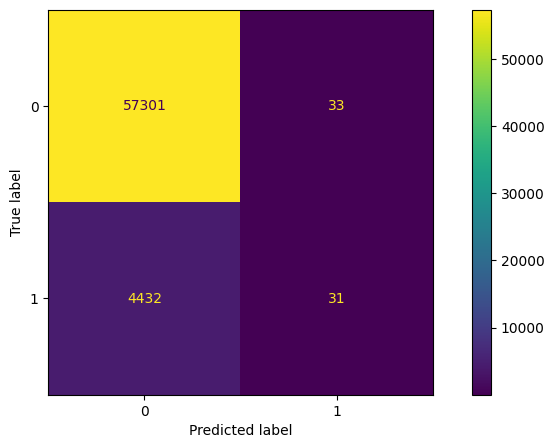

classification Error is : 7.23%


In [59]:
def check_feature_leakage(df, target):
    corr = df.corr()[target].sort_values(ascending=False)
    print("Korelasi fitur terhadap target:")
    print(corr)
    high_corr = corr[abs(corr) > 0.9].index.tolist()
    if target in high_corr:
        high_corr.remove(target)
    if len(high_corr) > 0:
        print(f"⚠️ Fitur dengan korelasi > 0.9 dengan target: {high_corr}")
        print("Cek apakah fitur ini mengandung informasi bocoran.")
    else:
        print("✅ Tidak ada fitur dengan korelasi sangat tinggi terhadap target.")

def info_func(df, target, method, ver=""):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing
    import matplotlib.pyplot as plt
    from sklearn import metrics
    import pandas as pd

    # Scaling data
    DF = df.copy()
    scal_s = preprocessing.StandardScaler()
    Ns = scal_s.fit_transform(DF.drop(columns=target))
    DFs = pd.DataFrame(Ns, columns=DF.drop(columns=target).columns.tolist())
    DFs[target] = DF[target]

    # Split data
    ts = 0.15
    x = DFs.drop(columns=target)
    y = DFs[target].values.reshape(-1,1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=ts, random_state=308)

    # Cek duplikasi train-test
    train_df = pd.DataFrame(x_train, columns=x.columns)
    train_df[target] = y_train.flatten()
    test_df = pd.DataFrame(x_test, columns=x.columns)
    test_df[target] = y_test.flatten()

    overlap = pd.merge(train_df, test_df, how='inner')
    if len(overlap) > 0:
        print(f"⚠️ WARNING: Ada {len(overlap)} data yang sama di train dan test. Potensi data leakage!")
    else:
        print("✅ Tidak ada data bocor antara train dan test.")

    # Cek distribusi label train-test
    print("Distribusi label di train:")
    print(train_df[target].value_counts(normalize=True))
    print("Distribusi label di test:")
    print(test_df[target].value_counts(normalize=True))

    # Modeling
    model = LogisticRegression()
    model.fit(x_train, y_train.ravel())

    # Accuracy Metrics
    print("Accuracy (seluruh data):", metrics.accuracy_score(y, model.predict(x)))
    print("Accuracy test:", metrics.accuracy_score(y_test, model.predict(x_test)))
    print("Accuracy train:", metrics.accuracy_score(y_train, model.predict(x_train)))
    print(metrics.classification_report(y, model.predict(x)))

    # Confusion Matrix
    cm = metrics.confusion_matrix(y, model.predict(x))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10, 5))
    cm_display.plot(ax=ax)
    plt.show()

    # Classification Error
    c = 0
    for i in range(len(DF[target].drop_duplicates())):
        for j in range(len(DF[target].drop_duplicates())):
            if i != j:
                c += cm[i][j]
    ce = c / float(len(DF.drop(columns=target)))
    print(f"classification Error is : {ce * 100:.2f}%")

    # Simpan hasil komparasi (optional)
    dfi = df.groupby(target).size().reset_index(name="Count")
    if method == "None":
        Compare["Method"].append("NoMethod")
    else:
        Compare["Method"].append(method.__class__.__name__ + ver)
    Compare["P_Count"].append(dfi[dfi[target] == 1].values[0][1])
    Compare["N_Count"].append(dfi[dfi[target] == 0].values[0][1])
    Compare["Score_P"].append(metrics.classification_report(y, model.predict(x), output_dict=True)["1"]["f1-score"])
    Compare["Score_N"].append(metrics.classification_report(y, model.predict(x), output_dict=True)["0"]["f1-score"])
    Compare["Score"].append(metrics.accuracy_score(y, model.predict(x)))

    return model


# Setelah preprocessing data, panggil fungsi cek korelasi fitur:
check_feature_leakage(df_, "diabetes")

# Kemudian panggil fungsi info_func dengan dataframe dan target:
model = info_func(df_, "diabetes", "None")


X = df_clean_out.drop(columns="diabetes").values
y = df_cleaned_out["diabetes"].values.reshape(-1,1)

# TEST

In [60]:
shareplot(df_,"diabetes")

✅ Tidak ada data bocor antara train dan test.
Distribusi label di train:
diabetes
0    0.927466
1    0.072534
Name: proportion, dtype: float64
Distribusi label di test:
diabetes
0    0.929558
1    0.070442
Name: proportion, dtype: float64
Accuracy (seluruh data): 0.9277473016489474
Accuracy test: 0.929126213592233
Accuracy train: 0.9275039503493442
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     57334
           1       0.48      0.01      0.01      4463

    accuracy                           0.93     61797
   macro avg       0.71      0.50      0.49     61797
weighted avg       0.90      0.93      0.89     61797



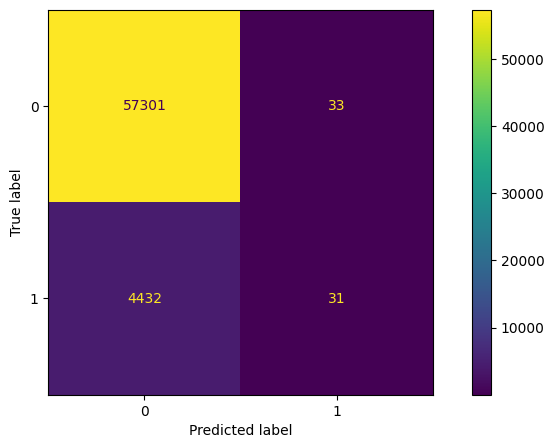

classification Error is : 7.23%


LogisticRegression()

In [61]:
info_func(df_,"diabetes","None")

In [62]:
X = df_.drop(columns="diabetes").values
Y = df_["diabetes"].values.reshape(-1,1)

# UNDERSAMPLING

In [63]:
from imblearn.under_sampling import InstanceHardnessThreshold

for i in range(30):
    B_method = under_sampling.InstanceHardnessThreshold(random_state=42,n_jobs=-1)
    x_IHT , y_IHT = B_method.fit_resample(X,Y)
    X = x_IHT;Y = y_IHT
newdf = pd.DataFrame(x_IHT);newdf["diabetes"]=y_IHT
newdf = newdf.reset_index(drop=True)

In [64]:
shareplot(newdf,"diabetes")

✅ Tidak ada data bocor antara train dan test.
Distribusi label di train:
diabetes
0    0.544118
1    0.455882
Name: proportion, dtype: float64
Distribusi label di test:
diabetes
0    0.559621
1    0.440379
Name: proportion, dtype: float64
Accuracy (seluruh data): 0.9910569105691057
Accuracy test: 0.9952574525745257
Accuracy train: 0.9903156384505022
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5377
           1       1.00      0.98      0.99      4463

    accuracy                           0.99      9840
   macro avg       0.99      0.99      0.99      9840
weighted avg       0.99      0.99      0.99      9840



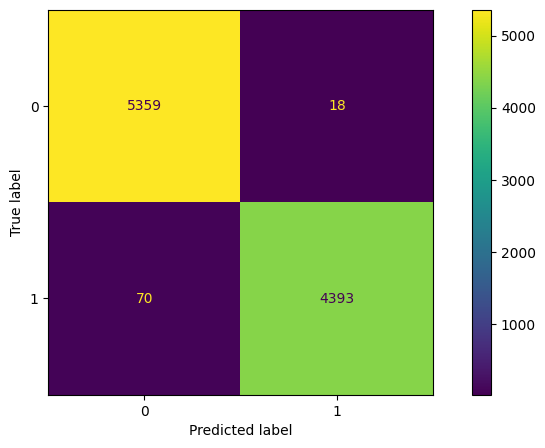

classification Error is : 0.89%


In [65]:
model = info_func(newdf, "diabetes", B_method)

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Ambil data baru hasil undersampling
X = newdf.drop(columns="diabetes").values
y = newdf["diabetes"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Standardisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [67]:
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(1, activation='sigmoid')  # mirip Logistic Regression
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5139 - loss: 0.9265 - val_accuracy: 0.7384 - val_loss: 0.6476
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8059 - loss: 0.6053 - val_accuracy: 0.8447 - val_loss: 0.4485
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8473 - loss: 0.4272 - val_accuracy: 0.8769 - val_loss: 0.3395
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8793 - loss: 0.3372 - val_accuracy: 0.9092 - val_loss: 0.2732
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8980 - loss: 0.2798 - val_accuracy: 0.9092 - val_loss: 0.2291
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8997 - loss: 0.2346 - val_accuracy: 0.9092 - val_loss: 0.1961
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8998 - loss: 0.2034 - val_accuracy: 0.9164 - val_loss: 0.1700
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9126 - loss: 0.1710 - val_accuracy: 0.

# SAVE MODEL

In [73]:
model.save('keras_model.h5')

In [69]:
import joblib
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [70]:
print(df['age'].unique())


[80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48]


# COBA MODEL

In [71]:
df_positif_diabetes = df[df['age'] == 15]
print(df_positif_diabetes.head())

     gender   age  hypertension  heart_disease smoking_history    bmi  \
16     Male  15.0             0              0           never  30.36   
36   Female  15.0             0              0         No Info  21.76   
165  Female  15.0             0              0           never  19.21   
334  Female  15.0             0              0           never  19.90   
395  Female  15.0             0              0         No Info  20.98   

     diabetes  
16          0  
36          0  
165         0  
334         0  
395         0  


In [74]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

# 1. Load data baru (atau bisa juga satu data manual sebagai dict)
data_baru = pd.DataFrame([{
    "age": 15,
    "hypertension": 0,
    "heart_disease": 0,
    "bmi": 21.76,
    "gender": "female",
    "smoking_history": "no invo"
}])

# 2. Lowercase untuk kolom kategorikal agar sesuai dengan encoding sebelumnya
data_baru['gender'] = data_baru['gender'].str.lower()
data_baru['smoking_history'] = data_baru['smoking_history'].str.lower()

# 3. Drop rows dengan gender 'other' jika ada
data_baru = data_baru[~(data_baru['gender'] == 'other')]

# 4. One-hot encoding manual agar sama dengan model training
# Buat kolom kosong default
for col in ['female', 'male']:
    data_baru[col] = (data_baru['gender'] == col).astype(int)

for col in ['never', 'no info', 'current', 'former', 'ever', 'not current']:
    data_baru[col] = (data_baru['smoking_history'] == col).astype(int)

# 5. Masukkan urutan kolom seperti yang digunakan saat training
final_columns = [
    'age', 'hypertension', 'heart_disease', 'bmi',
    'female', 'male',
    'never', 'no info', 'current', 'former', 'ever', 'not current'
]
X_baru = data_baru[final_columns]

# 6. Load scaler dan model
scaler = joblib.load('scaler.joblib')
model = load_model('keras_model.h5')

# 7. Transform data baru
X_baru_scaled = scaler.transform(X_baru)

# 8. Prediksi
prediksi = model.predict(X_baru_scaled)
prediksi_label = (prediksi > 0.5).astype(int)

# 9. Tampilkan hasil
print(f"Probabilitas diabetes: {prediksi[0][0]:.4f}")
print(f"Kategori Prediksi: {'Diabetes' if prediksi_label[0][0] == 1 else 'Tidak Diabetes'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Probabilitas diabetes: 0.2736
Kategori Prediksi: Tidak Diabetes
